# Evaluating Topic Models

## PyData Berlin 2017 Talk

#### This notebook is a companion to the talk I gave at the PyData Berlin 2017 conference on evaluating topic models

Unsupervised models in natural language processing (NLP) have a long history but have recently become very popular. Word2vec, GloVe, LSI and LDA provide powerful computational tools to deal with natural language and make exploring and modelling large document collections feasible.

Often evaluating the model output requires an existing understanding of what should come out. For topic models the output should reflect our understanding of the relatedness of topical categories, for instance **sports**, **travel** or **machine learning**. Distributional models of language such as `word2vec` and `GloVe` should capture some, or ideally all, of the semantics of how language is used.

This is a lot to ask! Not necessarily because it isn't learneable, after all we've learned it, but because we are not necessarily able to represent the desired output as an evaluation function and data set that can be optimised. As an example topic models are often evaluated with respect to the semantic coherence of the topics based on a set of top words from the topics. It is not clear if a set of words such as `{cat, dog, horse, pet}` captures the semantics of an animalness or a petsiness fully. Nevertheless these methods are useful in determining if the distributed word representation are capturing some of the information conveyed by words and if a topic model is understandable to a human.

This notebook explores a number of these issues in context and aims to provide an overview of the research that has been done in the past 10 or so years, mostly focusing on topic models.

The notebook is split into three parts

1. Eye Balling models
    - ways of making visual, manual inspection of models easier
2. Intrinsic Evaluation Methods
    - how to measure the internal coherence of topic models
3. Putting a Number on Human Judgements
    - quantitative methods for evaluating human judgement
---    
**Random collection of other stuff**

While preparing the talk and the notebook I experimented with a lot of different software packages and corpora. These are dumped as a somewhat unorganised collection of "other things" at the end of the notebook

# Why Evaluate Models

We would like to be able to say if a model is objectively good or bad, and compare different models to each other. This requires us to have an objective measure for the quality of the model but many of the tasks mentioned above require subjective evaluation.

In practical applications one needs to evaluate if "the correct thing" has been learned, often this means applying implicit knowledge and "eye-balling". Documents that talk about *football* should be in the same category and *cat* is more similar to *dog* than to *pen*. Ideally this information should be captured in a single metric that can be maximised. It is not clear how to formulate such a metric however, over the years there has been numerous attempts from various different angles at formulating semantic coherence, none capture the desired outcome fully and there are numerous issues one should be aware of in applying those metrics.

Some of the issues are related to the metrics being used or issues one should be aware of when applying those metrics, but others are related to external factors, like which kind of held out data to use. Natural language is messy, ambiguous and full of interpretation, that's where a lot of the expressive richness comes from. Sometimes trying to cleanse the ambiguity also reduces language to an unnatural form. 

----

# Topic Models

Topic models aim to capture the way in which words co-occur in the context of a document and divide the source corpus into some number of (soft) clusters. There are a large number of variations on the topic model, initial work was done be Deerwester in developing Latent Semantic Analysis (LSA/LSI), now the canonical example is Latent Dirichlet Allocation or LDA. The unit upon which topic models work is a sparse document-term matrix depicted below.

Each row is a document, each column is a term and the entries in each cell usually represent the frequency of each term in each document.

In [127]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

documents = ['The cat sat on the mat', 'A red cat sat on the mat', 'No cat sat on the mat']

vectoriser = CountVectorizer().fit(documents)
X = vectoriser.transform(documents)
pd.DataFrame(X.A, columns=sorted(vectoriser.vocabulary_.keys(), key=lambda k: vectoriser.vocabulary_[k])) 

cat  mat  no  on  red  sat  the
0    1    1   0   1    0    1    2
1    1    1   0   1    1    1    1
2    1    1   1   1    0    1    1

In the case of LDA a Bayesian model is fitted using the data from this matrix. Each topic in the model becomes a probability distribution over terms (the columns). Conceptually this is saying that semantic concepts can be represented as probabilities over a set of words. This makes sense as the topic of discussion acts as a limiting factor on the vocabulary one is likely to use, hear or read in the context of that dicussion.

Words relating to political campaining are much less likely to be observed in documents that discuss ice hockey. Notice however that is is *unlikely* not impossible, it is not the case that it can not ever happen, it is simply statistically less likely to be the case that *caucus* or *polling* will be in a document that otherwise discusses the Teemu Selänne retiring. A topic therefore is a probability distribution over the entire vocabulary, indicating how likely each word is to occur within that topic.

The documents the model is built over can be as short as a single sentence (a tweet) or as long as a chapter in a book. Typically very short documents tend to be more difficult to built coherent models over than slightly longer documents.

Open source implementation of the models are readily available
----

- Latent Semantic Indexing / Latent Semantic Analysis
    - http://radimrehurek.com/gensim/models/lsimodel.html
- Latent Dirichlet Allocation (LDA)
    - and its many many many variants
    - http://radimrehurek.com/gensim/models/ldamodel.html
    - http://mallet.cs.umass.edu/topics.php
- Hierarchical Dirichlet Process (HDP)
    - http://radimrehurek.com/gensim/models/hdpmodel.html
- Spherical Hierarchical Dirichlet Process (sHDP)
    - http://arxiv.org/pdf/1604.00126v1.pdf
    - https://github.com/Ardavans/sHDP

# A Model

In order to evaluate a model, we must of course have one. I'll use the same model(s), built from the Fake News data set on Kaggle, throughout this notebook.

In [4]:
import pandas as pd

df_fake = pd.read_csv('/usr/local/scratch/data/kaggle/fake.csv')
df_fake[['title', 'text', 'language']].head()

title  \
0  Muslims BUSTED: They Stole Millions In Gov’t B...   
1  Re: Why Did Attorney General Loretta Lynch Ple...   
2  BREAKING: Weiner Cooperating With FBI On Hilla...   
3  PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...   
4  FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...   

                                                text language  
0  Print They should pay all the back all the mon...  english  
1  Why Did Attorney General Loretta Lynch Plead T...  english  
2  Red State : \nFox News Sunday reported this mo...  english  
3  Email Kayla Mueller was a prisoner and torture...  english  
4  Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...  english

In [5]:
import numpy as np

df_fake = df_fake.loc[(pd.notnull(df_fake.text)) & (df_fake.language == 'english')]
df_fake.shape

(12357, 20)

There is a total of 12357 non empty english language documents, should be enough to build a model. Let's parse the documents using `spacy`, getting rid of some non content words and chuck that into `gensim`. I'll use the `gensim.corpora.MmCorpus` to serialise the text onto disk, this both saves memory and allows random access to the corpus, which will become useful later for creating different splits of the data. 

In [4]:
import spacy

import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary, MmCorpus

spc = spacy.load('en')

KEEP_POS = set([90, 98, 82, 84, 94])  # NOUN, VERB, ADJ, ADV, PROPN
pipe = spc.pipe(df_fake.text, parse=False, entity=False, n_threads=8)
processed = [[token.lemma_ for token in document if token.pos in KEEP_POS] for document in pipe]

vocabulary = Dictionary(processed)
vocabulary.filter_extremes(no_below=3, no_above=0.5)

In [133]:
MmCorpus.serialize('./fake_news.mm', (vocabulary.doc2bow(doc) for doc in processed))

In [8]:
vocabulary.save('./fake_news.vocab')

In [ ]:
del processed

In [5]:
corpus_fake = MmCorpus('./fake_news.mm')

In [137]:
lda_fake = LdaModel(corpus=corpus_fake, id2word=vocabulary, num_topics=35, chunksize=1500, iterations=200, alpha='auto')

Inspecting the top 6 six word from the model we can certainly identify some structure. Ther are topic about the Flint Michigan water crisis (Topic 11), the Dakota Access Pipeline (Topic 9) protests and the US elections.

In [7]:
pd.DataFrame([[word for rank, (word, prob) in enumerate(words)]
              for topic_id, words in lda_fake.show_topics(formatted=False, num_words=6, num_topics=35)].iloc[])

0           1           2              3            4  \
0           dna       video    abortion        veritas      project   
1            al      syrian       force          mosul       aleppo   
2         black       obama       white         people        soros   
3         china       which       alien          would        there   
4           get          go           ’           just         know   
5        russia     russian       putin           nato      missile   
6        market      cancer     product           bank        study   
7           use        drug      health        company       report   
8          post     comment    facebook           news        video   
9      pipeline      dakota      police          water         rock   
10        child      school      police         family         when   
11        water       study      health          toxic        flint   
12      clinton    campaign     hillary          email      podesta   
13      clinton     assange     hillary          there        trump   
14        obama       money        bank        hillary    president   
15        party        care       kelly      insurance    obamacare   
16        trump        vote     clinton       election      hillary   
17       people       world       other            man        which   
18      ukraine   ukrainian       india          japan    fukushima   
19       turkey     turkish       rebel            adl      erdogan   
20         text         god       which           moon         body   
21         fake  earthquake  california        rodgers          jay   
22        eddie  government      people        country        would   
23        which       would       egypt        britain         news   
24          war          us       syria         russia     military   
25       israel     israeli     nuclear           zika  palestinian   
26         life        time       other           year         find   
27         herb    universe       which          korea       planet   
28        trump    election         day           just           go   
29        trump       would   president         donald     election   
30  immigration   immigrant     illegal        percent      migrant   
31          law       court       judge           case      federal   
32         food      energy         oil           also          use   
33      clinton         fbi       email  investigation      hillary   
34         jews      jewish       which           mars         only   

             5  
0         know  
1         isis  
2      america  
3          ufo  
4        there  
5      nuclear  
6       report  
7      medical  
8       result  
9    protester  
10      people  
11         tea  
12   wikileaks  
13       would  
14        make  
15        year  
16       voter  
17        when  
18          us  
19     glacier  
20      silver  
21       quake  
22       which  
23      report  
24     country  
25  resolution  
26      people  
27           x  
28         get  
29     clinton  
30         new  
31  government  
32       which  
33       comey  
34    american

In [7]:
pd.DataFrame([[word for rank, (word, prob) in enumerate(words)]
              for topic_id, words in lda_fake.show_topics(formatted=False, num_words=6, num_topics=35)])

0           1           2              3            4  \
0           dna       video    abortion        veritas      project   
1            al      syrian       force          mosul       aleppo   
2         black       obama       white         people        soros   
3         china       which       alien          would        there   
4           get          go           ’           just         know   
5        russia     russian       putin           nato      missile   
6        market      cancer     product           bank        study   
7           use        drug      health        company       report   
8          post     comment    facebook           news        video   
9      pipeline      dakota      police          water         rock   
10        child      school      police         family         when   
11        water       study      health          toxic        flint   
12      clinton    campaign     hillary          email      podesta   
13      clinton     assange     hillary          there        trump   
14        obama       money        bank        hillary    president   
15        party        care       kelly      insurance    obamacare   
16        trump        vote     clinton       election      hillary   
17       people       world       other            man        which   
18      ukraine   ukrainian       india          japan    fukushima   
19       turkey     turkish       rebel            adl      erdogan   
20         text         god       which           moon         body   
21         fake  earthquake  california        rodgers          jay   
22        eddie  government      people        country        would   
23        which       would       egypt        britain         news   
24          war          us       syria         russia     military   
25       israel     israeli     nuclear           zika  palestinian   
26         life        time       other           year         find   
27         herb    universe       which          korea       planet   
28        trump    election         day           just           go   
29        trump       would   president         donald     election   
30  immigration   immigrant     illegal        percent      migrant   
31          law       court       judge           case      federal   
32         food      energy         oil           also          use   
33      clinton         fbi       email  investigation      hillary   
34         jews      jewish       which           mars         only   

             5  
0         know  
1         isis  
2      america  
3          ufo  
4        there  
5      nuclear  
6       report  
7      medical  
8       result  
9    protester  
10      people  
11         tea  
12   wikileaks  
13       would  
14        make  
15        year  
16       voter  
17        when  
18          us  
19     glacier  
20      silver  
21       quake  
22       which  
23      report  
24     country  
25  resolution  
26      people  
27           x  
28         get  
29     clinton  
30         new  
31  government  
32       which  
33       comey  
34    american

In [9]:
lda_fake.save('./fake_news_35.lda')

# Eye Ballin'

- usually ML models are evaluated and improved based on a scoring function whose gradient can be followed to a *hopefully* global minimum
- unsupervised models are tricky to evaluate because there usually isn't a suitable error function to optimise
- the unsupervised models still come with hyperparameters so how do you know when you've set them *correctly*
- furthermore, how do you know if model A is better than model B

### Termite

The visualisation in the `Termite` [paper](http://vis.stanford.edu/papers/termite) look very promising, but I've been unable to run the code. The original project has been split into two separate projects a *data server* and a *visualisation client*. Unfortunately the data server uses an unknown data format in SQLite databases, and the host server where the data sets ought to be is not operational anymore and the project hasn't been maintained since 2014.

The project also relies on `web2py` which at the moment only supports python 2 and there doesn't seem to be any interest in porting it to python 3.

Anyhow, it would seem to be possible to run the project under a python 2 environment.

- [Original project](https://github.com/StanfordHCI/termite)
- [Termite data server](https://github.com/uwdata/termite-data-server)
- [Termite visualisation](https://github.com/uwdata/termite-visualizations)

---

- modify `read_gensim.py` to add --sentence-splitter cmd arg
- modify `bin/apps/SplitSentences.py` to have an extra param for sentence_splitter jar location
- update code for `gensim` API breaking changes
    - `bin/readers/GensimReader.py` line 47 `ldamodel.show_topics`
    - `bin/readers/GensimReader.py` line 51 topic/term distribution does not neet `enumerate` anymore
    - `bin/readers/GensimReader.py` line 52 swap `term` and `value` around - they are the wrong way around
   
`termite` makes a lot of assumptions about paths, one needs to be quite careful what the root directory is for running the commands

---

In [22]:
import sys

sys.path.append('/home/matti/termite-data-server/bin/')

from modellers import GensimLDA

In [29]:
import re
df_fake['text_oneline'] = df_fake.text.apply(lambda s: re.sub(r'\s+', ' ', str(s)))

In [30]:
df_fake[['uuid', 'text_oneline']].to_csv('./fakenews.termite.tsv', sep='\t', header=False, index=False)

In [82]:
py27 = '/home/matti/miniconda3/envs/py27/bin/python'
termite_server_root = '/home/matti/termite-data-server/'

First we need to import the corpus into `termite`'s own special SQLite format

In [76]:
!mkdir termite;\
    cp ./fakenews.termite.tsv ./termite;
    cd termite; $py27 /home/matti/termite-data-server/bin/import_corpus.py ./db ./fakenews.termite.tsv

mkdir: cannot create directory ‘termite’: File exists
Importing file [./fakenews.termite.tsv] into database [./db/corpus.db]


Then we need to export that SQLite DB back into a text corpus, there's some magic file names and path structures that happens here so you can't just use the original file

In [79]:
!cd termite; mkdir corpus; $py27 /home/matti/termite-data-server/bin/export_corpus.py ./db ./corpus/corpus.txt

Exporting database [./db/corpus.db] to file [./corpus/corpus.txt]


Then train the LDAModel, is should be possible to skip this and just use any model trained with `gensim`

In [81]:
%capture
!cd termite; $py27 /home/matti/termite-data-server/bin/train_gensim.py --overwrite ./corpus ./models/

--------------------------------------------------------------------------------
Training an LDA topic model using gensim...
       corpus = ./corpus/corpus.txt
        model = ./models/
  token_regex = \w{3,}
       topics = 20
       passes = 1
--------------------------------------------------------------------------------
using symmetric alpha at 0.05
using symmetric eta at 3.17268948888e-05
using serial LDA version on this node
running online (single-pass) LDA training, 20 topics, 1 passes over the supplied corpus of 12357 documents, updating model once every 2000 documents, evaluating perplexity every 12357 documents, iterating 50x with a convergence threshold of 0.001000
too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
PROGRESS: pass 0, at document #2000/12357
merging changes from 2000 documents into a model of 12357 documents
topic #0 (0.050): 0.003*"black" + 0.003*"obama" + 0.003*"syria" + 0.002*"white" + 

Finally, read in the trained `gensim` LDA model to `termite` creating all the necessary data structures for the visualisations to work. This computes, among other thigs, term collocations ($N^2$) so it's going to take a while to run, especially for large vocabularies.

If you set all the paths consistently during the previous steps, this should just work. If not, it's likely there will be some `FileNotFound` errors.

In [88]:
%capture
!cd termite; cp -r $termite_server_root/tools ./; $py27 /home/matti/termite-data-server/bin/read_gensim.py --overwrite\
  --sentence-split /home/matti/termite-data-server/utils/corenlp/SentenceSplitter.jar\
  gensim_termite ./models/ ./corpus ./db

--------------------------------------------------------------------------------
INFO:termite:--------------------------------------------------------------------------------
Import a gensim LDA topic model as a web2py application...
INFO:termite:Import a gensim LDA topic model as a web2py application...
           app_name = gensim_termite
INFO:termite:           app_name = gensim_termite
           app_path = apps/gensim_termite
INFO:termite:           app_path = apps/gensim_termite
         model_path = ./models/
INFO:termite:         model_path = ./models/
    corpus_filename = ./corpus/corpus.txt
INFO:termite:    corpus_filename = ./corpus/corpus.txt
  database_filename = ./db/corpus.db
INFO:termite:  database_filename = ./db/corpus.db
--------------------------------------------------------------------------------
INFO:termite:--------------------------------------------------------------------------------
Creating app: gensim_termite [apps/temp_20170623_234907_893474_8228]
INFO:

To start the server and see the visualisations

In [91]:
!$py27 $termite_server_root/web2py/web2py.py

web2py Web Framework
Created by Massimo Di Pierro, Copyright 2007-2017
Version 2.9.5-stable+timestamp.2014.03.16.02.35.39
Database drivers available: SQLite(sqlite3), MySQL(pymysql), PostgreSQL(pg8000), MSSQL(pyodbc), DB2(pyodbc), Teradata(pyodbc), Ingres(pyodbc), IMAP(imaplib)


---

### pyLDAVis

Some of the work from `Termite` has been integrated into `pyLDAVis` which is being maintained and has good interoperability with `gensim`. Below is an interactive visualisation of the fake news model trained earlier. Just to see how informative the visualisation is overall, I'll train another model on the same dataset but increaase the number of topics quite a lot.

For a good description of what you see in the visualisation you can look at the presenation from the creator himself
- https://www.youtube.com/watch?v=tGxW2BzC_DU&index=4&list=PLykRMO7ZuHwP5cWnbEmP_mUIVgzd5DZgH

In [6]:
lda_fake = LdaModel.load('./fake_news_35.lda')

In [15]:
from gensim.models import LdaModel

import pyLDAvis as ldavis
import pyLDAvis.gensim

ldavis.enable_notebook()
prepared_data = ldavis.gensim.prepare(lda_fake, corpus_fake, vocabulary)

with open('./fake_news_35.lda-LDAVIS.json', 'w') as fh:
    fh.write(prepared_data.to_json())

prepared_data

/home/matti/miniconda3/envs/pydatabln17/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
29     11.447637        1       1  0.082591 -0.032010
4       9.925250        1       2  0.097223  0.002993
17      6.863440        1       3  0.070678  0.060930
24      6.391857        1       4 -0.099389 -0.093486
10      6.215024        1       5  0.025561  0.019992
33      5.125329        1       6  0.079203 -0.077926
16      4.943909        1       7  0.124447 -0.090639
32      3.707930        1       8 -0.018592  0.108385
26      3.619673        1       9  0.035902  0.159298
12      2.973363        1      10  0.094758 -0.114335
2       2.618891        1      11  0.084051 -0.039053
22      2.605856        1      12 -0.002146  0.031591
28      2.365484        1      13  0.104745 -0.020990
3       2.230207        1      14 -0.003457 -0.001501
14      2.170824        1      15  0.080176 -0.044981
1       2.164036        1      16 -0.207172 -0.063851
7       2.051219        1      17 -0.025224  0.072326
31      1.905628        1      18  0.001047 -0.080677
5       1.878165        1      19 -0.190224 -0.082225
34      1.877073        1      20  0.048179  0.081136
9       1.641252        1      21 -0.068508 -0.075266
8       1.591013        1      22  0.053924 -0.055139
25      1.546481        1      23 -0.063104  0.033000
13      1.477075        1      24  0.069060 -0.058268
23      1.422065        1      25 -0.035523 -0.058256
20      1.274483        1      26  0.002839  0.187242
30      1.265534        1      27 -0.012395 -0.002334
6       1.250676        1      28 -0.098291  0.135197
27      1.055358        1      29  0.023037  0.042058
15      0.972797        1      30  0.100407 -0.001857
11      0.918695        1      31 -0.054265  0.227490
0       0.908526        1      32  0.066014 -0.032872
18      0.725771        1      33 -0.159045 -0.067844
19      0.511822        1      34 -0.147986 -0.051901
21      0.357659        1      35 -0.058521 -0.016227, topic_info=      Category          Freq         Term         Total  loglift  logprob
term                                                                     
169    Default  23123.000000      clinton  23123.000000  30.0000  30.0000
259    Default  23764.000000        trump  23764.000000  29.0000  29.0000
2163   Default   8522.000000       russia   8522.000000  28.0000  28.0000
168    Default  15102.000000      hillary  15102.000000  27.0000  27.0000
86     Default   9902.000000        obama   9902.000000  26.0000  26.0000
2157   Default   5248.000000      russian   5248.000000  25.0000  25.0000
171    Default   8678.000000        email   8678.000000  24.0000  24.0000
164    Default   5485.000000          fbi   5485.000000  23.0000  23.0000
684    Default  12109.000000     election  12109.000000  22.0000  22.0000
5959   Default   3514.000000        water   3514.000000  21.0000  21.0000
284    Default   7665.000000         vote   7665.000000  20.0000  20.0000
903    Default  10924.000000           us  10924.000000  19.0000  19.0000
2231   Default  10453.000000          war  10453.000000  18.0000  18.0000
2413   Default   4837.000000        syria   4837.000000  17.0000  17.0000
414    Default   7975.000000     campaign   7975.000000  16.0000  16.0000
519    Default   4151.000000       police   4151.000000  15.0000  15.0000
882    Default   4064.000000        black   4064.000000  14.0000  14.0000
287    Default   6493.000000          law   6493.000000  13.0000  13.0000
847    Default   6915.000000         post   6915.000000  12.0000  12.0000
1432   Default   5448.000000     military   5448.000000  11.0000  11.0000
131    Default  18060.000000        which  18060.000000  10.0000  10.0000
271    Default  20053.000000       people  20053.000000   9.0000   9.0000
688    Default   4407.000000        voter   4407.000000   8.0000   8.0000
158    Default   7240.000000         news   7240.000000   7.0000   7.0000
1131   Default   5742.000000       

In [6]:
lda_fake_100 = LdaModel(corpus=corpus_fake, id2word=vocabulary, num_topics=100, alpha='auto')

In [8]:
lda_fake_100.save('./fake_news_100.lda')

In [10]:
prepared_data = ldavis.gensim.prepare(lda_fake_100, corpus_fake, vocabulary)

with open('./fake_news_100.lda-LDAVIS.json', 'w') as fh:
    fh.write(prepared_data.to_json())

/home/matti/miniconda3/envs/pydatabln17/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


In [14]:
prepared_data

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
15     11.051638        1       1 -0.020584 -0.068551
91      4.765352        1       2  0.076791 -0.120859
27      3.519617        1       3  0.084229  0.006596
65      3.288228        1       4  0.059327 -0.130154
64      3.123180        1       5  0.055230 -0.131222
4       3.076409        1       6  0.046018 -0.029117
63      3.061538        1       7  0.112877  0.090508
35      2.962981        1       8  0.043305 -0.143161
97      2.667694        1       9  0.010568 -0.009419
95      2.625079        1      10  0.014559 -0.079037
88      2.350658        1      11  0.021777  0.031932
94      2.112345        1      12  0.129587  0.091645
76      2.071964        1      13 -0.112160  0.024069
98      1.925515        1      14  0.045811  0.027955
84      1.808213        1      15  0.156204  0.017993
92      1.714718        1      16 -0.136366  0.087464
30      1.652883        1      17  0.019563  0.015719
38      1.571009        1      18 -0.025832 -0.092534
51      1.543033        1      19 -0.079080 -0.020177
12      1.523709        1      20 -0.025641 -0.032598
8       1.442071        1      21 -0.178847  0.022802
50      1.388350        1      22  0.139298  0.112845
69      1.323889        1      23 -0.110300  0.029187
34      1.323022        1      24  0.006861  0.021670
86      1.213996        1      25  0.049684  0.105667
14      1.191569        1      26  0.137705 -0.001965
80      1.121070        1      27  0.040091 -0.148196
22      1.113610        1      28  0.028684 -0.088641
87      1.103358        1      29  0.131680  0.134262
43      1.095135        1      30  0.103508  0.169236
...          ...      ...     ...       ...       ...
66      0.284486        1      71 -0.070199 -0.023971
19      0.277730        1      72  0.041505  0.053897
26      0.276471        1      73 -0.012452  0.015477
29      0.272207        1      74 -0.014223 -0.001802
56      0.270535        1      75 -0.059576  0.025650
47      0.266134        1      76 -0.053632  0.004143
32      0.246424        1      77 -0.028769 -0.012899
93      0.232488        1      78 -0.051844 -0.042669
37      0.230586        1      79  0.022239  0.079171
41      0.219533        1      80  0.013315 -0.023044
25      0.214723        1      81  0.017702 -0.020328
83      0.189997        1      82 -0.018200  0.026752
13      0.180659        1      83  0.044520 -0.032618
21      0.167724        1      84 -0.008503 -0.040216
57      0.167108        1      85  0.067977  0.020235
74      0.158762        1      86 -0.022937 -0.033824
31      0.148276        1      87  0.023512  0.049431
6       0.131437        1      88 -0.023286  0.066083
7       0.130565        1      89 -0.050323  0.155394
3       0.128582        1      90  0.058498  0.040850
39      0.123680        1      91 -0.070594  0.043534
62      0.122406        1      92 -0.020730  0.003200
40      0.116530        1      93 -0.034095 -0.015120
67      0.112451        1      94 -0.073535  0.067852
61      0.102738        1      95 -0.029518  0.014581
82      0.100426        1      96  0.014365  0.059540
60      0.091150        1      97  0.056015  0.118169
5       0.090763        1      98  0.051519  0.042521
1       0.065789        1      99 -0.013541  0.071367
68      0.058966        1     100 -0.008670  0.029212

[100 rows x 5 columns], topic_info=       Category          Freq         Term         Total  loglift  logprob
term                                                                      
259     Default  23991.000000        trump  23991.000000  30.0000  30.0000
169     Default  23402.000000      clinton  23402.000000  29.0000  29.0000
903     Default  11008.000000           us  11008.000000  28.0000  28.0000
168     Default  15524.000000      hillary  15524.000000  27.0000  27.0000
684     Default  12343.000000     election  12343.000000  26.0000  26.0000
171   

Comparing the two visualisation one can make some comforting observations. In the bottom left right corner in both visualisation there is a cluster of topics relating to the 2016 U.S. presidential election. The 100 topic model has split the documents up in slightly more specific terms but otherwise both models have captured those semantics and more importantly both visualisations display those topics consistently in a cluster.

Similarly in the visualisation of the 100 topic model the cluster in the top right hand corner is semantically coherent and similar to the cluster in the bottom left hand corner in the visualisation for the 35 topic model. Again both models have captured the Syrian civil war and related issues and consistently placed those topics close together in the topic panel. 

The main problem I find the LDAVis is that the spatial dimensions on the left hand side panel are somewhat meaningless.

The area of the circle shows the prevalence of a topic, but visually determining the relative sizes of circles is difficult to do, so while you do get an understanding of which topics are the most important you can't really determine how much more important those topics are compared to the others.

The second problem is the distance between the topics. While the positioning of the topics to some exent preserves semantic similarity allowing some related topics to form clusters, it is a little difficult to determine exactly how similar the topics are. To be fair this is not something that can be blamed on LDAVis as measuring the semantic similarity of topics and then collapsing the multidimensional similarity vectors into 2 dimensions is not an easy task to do. Nevertheless, one shouldn't read too much into the topic distances. Different algorithms for computing the locations - essentially doing multidimensional scaling.

# Intrinsic Evaluation

Perplexity is often used as an example of an intrinsic evaluation measure. It comes from the language modelling community and aims to capture how suprised a model is of new data it has not seen before. This is commonly measured as the normalised log-likelihood of a held out test set

$$
\begin{align}
\mathcal{L}(D') &= \frac{\sum_D \log_2 p(w_d;\Theta)}{\mbox{count of tokens}}\\\\
perplexity(D') &= 2^{-\mathcal{L}(D')}
\end{align}
$$

Focussing on the log-likelihood part, this metric is measuring how probable some new unseen data is given the model that was learned earlier. That is to say, how well does the model represent or reproduce the statistics of the held out data.

Thinking back to what we would like the topic model to do, this makes no sense at all. Let's put aside any specific algorithm for inferring a topic model and focus on what it is that we'd like the model to capture. More often than not the desire is for the model to capture *concepts* that exist in a particular dataset. Well what is a concept and how can it be represented given the pieces we have?

Let me offer a way of thinking about this that would not pass the mustard in a bachelor's class in philosophy. Luckily we're not in philopshy class at the moment.

Take the following two documents that talk about ice hockey. I've highlighted terms that **I** think are related to the subject matter, you may disagree with my judgement. Notice that among the terms that I've highlighted as being part of the *topic* of Ice Hockey are words such as `Penguin`, `opposing` and `shots`. None of these on the face of it would appear to "belong" to Ice Hockey, but seeing them in context makes it clear that `Penguin` refers to the ice hockey team, `shots` refers to disk shaped pieces of vulcanised rubber being launched at the goal at various different speeds and `opposing` refers to the opposing team although it might more commonly be thought to belong politics or the debate club.

> ... began his professional **career** in 1989–90 with **Jokerit** of the **SM-liiga** and **played** 21 **seasons** in the **National Hockey League** (**NHL**) for the **Winnipeg Jets** ...

> **Rinne** **stopped** 27 of 28 **shots** from the **Penguins** in **Game** 6 at home Sunday, but that lone **goal** allowed was enough for the **opposition** to break out the **Stanley Cup** **trophy** for the second straight **season**.

Given the terms that I've determined to be a partial description of Ice Hockey (the concept), one could conceivably measure the coherence of that concept by counting how many times those terms occur with each other - co-occur that is - in some sufficiently large reference corpus.

One of course encounters a problem should the reference corpus never refer to ice hockey. A poorly selected reference corpus could for instance be patent applications from the 1800s, it would be unlikely to find those word pairs in that text.

This is precisely what several research papers have aimed to do. To take the top words from the topics in a topic model and measure the *support* for those words forming a coherent concept / topic by looking at the co-occurrences of those terms in a reference corpus. The research up to now was finally wrapped up into a single paper where the authors develop a *coherence pipeline*, which allows plugging in all the different methods into a single framework. This *coherence pipeline* is partially implemented in `gensim`, below is a few examples on how to use it.

In [6]:
import spacy

import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary, MmCorpus

spc = spacy.load('en')

KEEP_POS = set([90, 98, 82, 84, 94])  # NOUN, VERB, ADJ, ADV, PROPN
pipe = spc.pipe(df_fake.text, parse=False, entity=False, n_threads=8)
processed = [[token.lemma_ for token in document if token.pos in KEEP_POS] for document in pipe]

vocabulary = Dictionary(processed)
vocabulary.filter_extremes(no_below=3, no_above=0.5)

In [10]:
corpus = MmCorpus('./models/fake_news.mm')

In [14]:
lda_fake_35 = LdaModel.load('./models/fake_news_35.lda')
lda_fake_100 = LdaModel.load('./models/fake_news_100.lda')

In [11]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=lda_fake_35, corpus=corpus,
                    dictionary=vocabulary, coherence='c_v',
                    texts=[[w for w in d if w in vocabulary.token2id] for d in processed])
cm.get_coherence()

0.73858095241592736

In [19]:
cm = CoherenceModel(model=lda_fake_100, corpus=corpus,
                    dictionary=vocabulary, coherence='c_v',
                    texts=[[w for w in d if w in vocabulary.token2id] for d in processed])
cm.get_coherence()

0.6594566862444563

In [12]:
cm = CoherenceModel(model=lda_fake_35, corpus=corpus,
                    dictionary=vocabulary, coherence='c_uci',
                    texts=[[w for w in d if w in vocabulary.token2id] for d in processed])
cm.get_coherence()

0.51052624873338692

In [15]:
cm = CoherenceModel(model=lda_fake_100, corpus=corpus,
                    dictionary=vocabulary, coherence='c_uci',
                    texts=[[w for w in d if w in vocabulary.token2id] for d in processed])
cm.get_coherence()

-0.84043127015386343

In [20]:
cm = CoherenceModel(model=lda_fake_35, corpus=corpus,
                    dictionary=vocabulary, coherence='u_mass',
                    texts=[[w for w in d if w in vocabulary.token2id] for d in processed])
cm.get_coherence()

-1.6535058835918122

In [21]:
cm = CoherenceModel(model=lda_fake_100, corpus=corpus,
                    dictionary=vocabulary, coherence='u_mass',
                    texts=[[w for w in d if w in vocabulary.token2id] for d in processed])
cm.get_coherence()

-3.8603367679749985

---

# References

## Papers
- Chang et. al *Reading Tea Leaves: How Humans Interpret Topic Models*, NIPS 2009
- Wallach et. al *Evaluation Methods for Topic Models*, ICML 2009 
- Lau et. al *Machine Reading Tea Leaves: Automatically Evaluating Topic Coherence and Topic Model Quality*, ACL 2014
- Röder et. al *Exploring the Space of Topic Coherence Methods*, Web Search and Data Mining 2015

- Sievert et. al *LDAvis: A method for visualizing and interpreting topics* ACL 2014 Workshop on Interactive Language Learning, Visualization, and Interfaces

- Chuang et. al *Termite: Visualization Techniques for Assessing Textual Topic Models*, AVI 2012 [link](http://vis.stanford.edu/papers/termite)
- Chuang et. al *Topic Model Diagnostics: Assessing Domain Relevance via Topical Alignment*, ICML 2013 [link](http://vis.stanford.edu/papers/topic-model-diagnostics)

## Software

- [gensim Topic Modelling for Humans](http://radimrehurek.com/gensim) (Python)
- [UMass Machine Learning for Language - Mallet](http://mallet.cs.umass.edu/) (Java)
- [Stanford Topic Modelling Toolbox](https://nlp.stanford.edu/software/tmt/tmt-0.3/) (Java)
- [Spherical Hierarchical Dirichlet Processes](https://github.com/Ardavans/sHDP)
- Termite
    - [Original project](https://github.com/StanfordHCI/termite)
    - [Data server](https://github.com/uwdata/termite-data-server)
    - [Visualisation](https://github.com/uwdata/termite-visualizations)
- scattertext
    - scattertext allows you to plot differential word usage patterns from two corpora into an interactive display. It's not exactly an evaluation method for topic models but can be quite useful for analysing corpora
    - there's a talk by the creator at PyData Seattle 2017 [link](https://pydata.org/seattle2017/schedule/presentation/69/)

## Datasets

The model used in this notebook is built on the Kaggle Fake News dataset available [here](https://www.kaggle.com/mrisdal/fake-news). 

## Interwebs

- http://qpleple.com/perplexity-to-evaluate-topic-models/
- http://qpleple.com/topic-coherence-to-evaluate-topic-models/

## General stuff about NLP you might be interested in
- Yoav Goldberg on evaluating NNLMs
    - [Original post](https://medium.com/@yoav.goldberg/an-adversarial-review-of-adversarial-generation-of-natural-language-409ac3378bd7)
    - [Addendum](https://medium.com/@yoav.goldberg/clarifications-re-adversarial-review-of-adversarial-learning-of-nat-lang-post-62acd39ebe0d)
    - [Yann le Cunn on the matter](https://www.facebook.com/yann.lecun/posts/10154498539442143)
    - [A response to le Cunn](https://medium.com/@yoav.goldberg/a-response-to-yann-lecuns-response-245125295c02)

----
----

# Even Remotely Intelligent Stuff Ends Here

----
----

I am going to start with a slightly silly example that nonetheless nicely illustrates a few important points about evaluating unsupervised models

- define what you want out of the model
    - running an algorithm won't solve anything unless you have an expectation of what the output should / could look like
    - if you don't explicitly know what the output should look like, you probably know it implicitly

- applying subjective judgement

I did some analysis on the accepted talks to PyData Berlin 2017 to find out what kind of talks were accepted this year. I plotted the results in a wordcloud (github.com/amueller/word_cloud), but was disappointed that the first approach didn't really reveal _the thing I was hoping to analyse_. The plot just showed general patterns of english language use.

![Raw Frequency of Words](../assets/unsupervised-models/wordcloud.1.png)

Filtering out high frequency words helped a little bit but the wordcloud still wasn't that informative, it is hardly a surprise that _data_ is a central theme at a PyData conference.

![Raw Frequency of Words, 0.5 lt doc_freq removed](../assets/unsupervised-models/wordcloud.2.png)

So I made some more adjustments to the model and got something that looks more reasonable.

![TFIDF filtered scores](../assets/unsupervised-models/wordcloud.4.png)

I am not trying to claim that the last model is a good one, or even a valid one, but it does correspond to my previously held beliefs of the contents of the conference. It is not surprising that is the case since I arrived at the model by iterating through a number of models that I found to be unsatisfactory, the problem is that I never I actually defined what satisfactory means, there was never an explicitly stated goal towards which I was driving.

This is extremely important to keep in mind as evaluation metrics for unsupervised models often have in built assumptions about what a _good model_ looks like. Those assumptions may or may not be true for your use case. Some metrics aim to satisfy internal constraints 

So let's start with what we would like to model about text in an unsupervised manner

- the distribution of terms
- the co-occurence of terms
    - within documents (topic modelling)
    - within "sentences" (distributional semantics, word2vec, GloVe)
- sequences of terms (language models)

I will focus on evaluation topic models and models of distributional semantics.

- open source tools
- open access research papers

- data visualisation is not my core research area
- I am not a political analyst or social scientist, my background is in computer science 

---

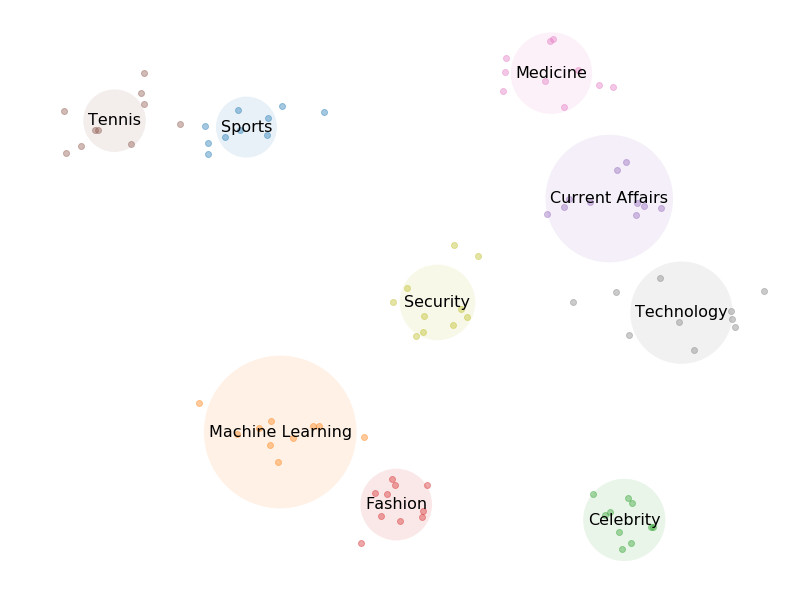

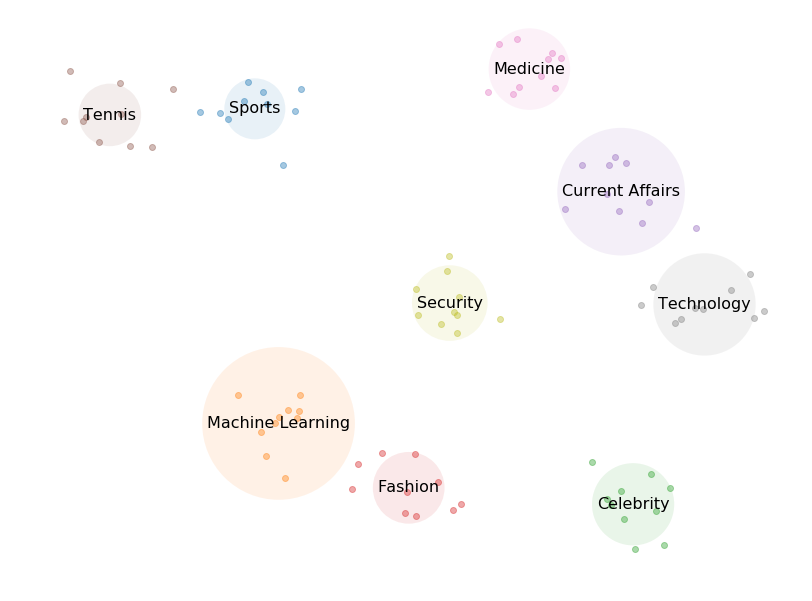

In [104]:
import numpy as np
import scipy
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(1000/72, 750/72), dpi=72)

topics = ['Sports', 'Machine Learning', 'Celebrity', 'Fashion', 'Current Affairs', 'Tennis', 'Medicine', 'Technology', 'Security']
# centers = np.random.randint(low=0, high=20, size=(len(topics), 2))
for topic_name, center in zip(topics, centers): 
    topic = np.random.normal(loc=center, scale=1.0, size=(10, 2))
    dots = ax.scatter(topic[:, 0], topic[:, 1], alpha=0.4)
    bbox_props = dict(boxstyle="circle, pad=0.3", fc=dots.get_facecolor().ravel(), ec="none", alpha=0.1, lw=1)
    t = ax.text(*topic.mean(axis=0), topic_name, ha="center", va="center", rotation=0,
                size=16, bbox=bbox_props)
plt.axis("off");
plt.show()
# plt.savefig('../assets/unsupervised-models/ideal-topics.png')

This is what could be called a coherent interpretable model

- all clusters are more or less self contained
- related clusters _seem_ to be close together

The problem here is that the "model" above is entirely made up, and the division is somewhat non sensical.

*Topic Models* have a number of ways of being evaluated, including

- perplexity (might not be such a great measure)
    - Chang et. al Reading Tea Leaves: How Humans Interpret Topic Models, NIPS 2009
    - Wallach et. al Evaluation Methods for Topic Models, ICML 2009 
    - Lau et. al Machine Reading Tea Leaves: Automatically Evaluating Topic Coherence and Topic Model Quality, ACL 2014
- topic coherence
    - Röder et. al Exploring the Space of Topic Coherence Methods, Web Search and Data Mining 2015
- human interpretability (word or topic intrusion)
    - Machine Reading Tea Leaves: Automatically Evaluating Topic Coherence and Topic Model Quality
- ontological similarity to link overlap and term co-occurrence (WordNet)
- inter-annotator agreement on labels for topics
- an external task
    - information retrieval (Wei et. al LDA-Based Document Models for Ad-hoc Retrieval, 2006 SIGIR)
    - sentiment analysis (Titov et. al A Joint Model of Text and Aspect Ratings for Sentiment Summarization, ACL 2008)

# Perplexity and Other Internal Evaluation Metrics 

Perplexity is a metric for the goodness of fit, it measures the log likelihood of held out data.

$$ 2^{-\sum_x \tilde p(x)\,log_2\,p(x)}$$

The aim is to capture how well the current estimated probability of words predicts the probability of words in a held out dataset. This measure is used internally by topic models the measure the progress of learning the topics. It is not suitable for human evaluation as a model with low perplexity does not necessarily correspond to a model that is interpretable or informative (Reading Tea Leaves: How Humans Interpret Topic Models).

There is a review of internal evaluation measures in Wallach et. al _Evaluation methods for topic models. In ICML. 2009_ - these measures borrow from the language modelling research.

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Topic ID</th>      <th>0</th>      <th>1</th>      <th>2</th>      <th>3</th>      <th>4</th>      <th>5</th>      <th>6</th>      <th>7</th>      <th>8</th>      <th>9</th>      <th>10</th>      <th>11</th>      <th>12</th>      <th>13</th>      <th>14</th>    </tr>    <tr>      <th>model</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>1</th>      <td>get</td>      <td>i'll</td>      <td>light</td>      <td>at</td>      <td>he</td>      <td>come</td>      <td>got</td>      <td>go</td>      <td>was</td>      <td>blues</td>      <td>will</td>      <td>oh</td>      <td>dance</td>      <td>over</td>      <td>she</td>    </tr>    <tr>      <th>1</th>      <td>gonna</td>      <td>never</td>      <td>night</td>      <td>down</td>      <td>his</td>      <td>me,</td>      <td>they</td>      <td>we're</td>      <td>now</td>      <td>are</td>      <td>let</td>      <td>do</td>      <td>(i</td>      <td>been</td>      <td>her</td>    </tr>    <tr>      <th>1</th>      <td>yeah,</td>      <td>see</td>      <td>shine</td>      <td>old</td>      <td>him</td>      <td>better</td>      <td>up</td>      <td>hey</td>      <td>never</td>      <td>as</td>      <td>heart</td>      <td>want</td>      <td>back</td>      <td>oh,</td>      <td>she's</td>    </tr>    <tr>      <th>1</th>      <td>yeah</td>      <td>you're</td>      <td>sun</td>      <td>out</td>      <td>man</td>      <td>if</td>      <td>ain't</td>      <td>-</td>      <td>have</td>      <td>day</td>      <td>our</td>      <td>baby</td>      <td>ah</td>      <td>long</td>      <td>girl</td>    </tr>    <tr>      <th>1</th>      <td>wanna</td>      <td>way</td>      <td>tonight</td>      <td>run</td>      <td>he's</td>      <td>do</td>      <td>out</td>      <td>let's</td>      <td>were</td>      <td>good</td>      <td>are</td>      <td>can't</td>      <td>bring</td>      <td>gone</td>      <td>woman</td>    </tr>    <tr>      <th>NaN</th>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>    </tr>    <tr>      <th>2</th>      <td>oh</td>      <td>want</td>      <td>get</td>      <td>out</td>      <td>she</td>      <td>down</td>      <td>light</td>      <td>am</td>      <td>wanna</td>      <td>blues</td>      <td>if</td>      <td>are</td>      <td>hey,</td>      <td>he</td>      <td>was</td>    </tr>    <tr>      <th>2</th>      <td>baby</td>      <td>do</td>      <td>ya</td>      <td>gloom</td>      <td>her</td>      <td>look</td>      <td>our</td>      <td>thro'</td>      <td>up</td>      <td>old</td>      <td>you,</td>      <td>they</td>      <td>ah</td>      <td>his</td>      <td>now</td>    </tr>    <tr>      <th>2</th>      <td>gonna</td>      <td>if</td>      <td>ain't</td>      <td>off</td>      <td>she's</td>      <td>down,</td>      <td>will</td>      <td>lord</td>      <td>get</td>      <td>new</td>      <td>would</td>      <td>where</td>      <td>ha</td>      <td>him</td>      <td>out</td>    </tr>    <tr>      <th>2</th>      <td>oh,</td>      <td>can't</td>      <td>got</td>      <td>black</td>      <td>girl</td>      <td>at</td>      <td>as</td>      <td>run</td>      <td>la</td>      <td>-</td>      <td>could</td>      <td>home</td>      <td>ah,</td>      <td>man</td>      <td>one</td>    </tr>    <tr>      <th>2</th>      <td>yeah</td>      <td>i'll</td>      <td>na</td>      <td>them</td>      <td>got</td>      <td>stop</td>      <td>rain</td>      <td>jesus</td>      <td>let's</td>      <td>hey</td>      <td>me,</td>      <td>people</td>      <td>my,</td>      <td>he's</td>      <td>at</td>    </tr>  </tbody></table>


# Topic Coherence Model

Röder et. al Exploring the Space of Topic Coherence Measures, WSDM 2015

The topic coherence model combines a number of papers into one framework that allows evaluating the *coherence* of topics inferred by a topic model. In the context of this work coherence is defined as the mutual support of sets of facts - facts are represented by the top N *words* from a topic.

1. create tuples from the top N words in a topic
    - pairs of single words `{(game), (ball)}, {(team), (ball)}`
    - pairs of pairs of words `{(game, ball)}, {(team, ball)}`
    - ...

2. measure the probability of those from a reference corpus
    - document probability
    - word probability
    - ...
    
3. calculate a *confirmation measure* per tuple 
    - UCI normalised sum over PMI values
    - UMASS
    - NPMI
    - ...

4. aggregate over all the tuples *mean*

$$ C_{UCI} = \frac{2}{N * (N-1)} \sum_{i-1}^{N-1} \sum_{j = i+1}^{N} PMI(w_i, w_j) $$

where PMI is

$$ PMI(w_i, w_j) = \log \frac{P(w_i, w_j) + \epsilon}{P(w_i)P(w_j)}$$

As pointed out in Reading Tea Leaves: How Humans Interpret Topic Models [emphasis mine].

> We emphasize that not measuring the **internal representation** of topic models is at odds with their presentation and development. Most topic modeling papers display qualitative assessments of the inferred topics or simply **assert that topics are semantically meaningful** ...

As we can see above, it is not immediately clear how the topics are semantically meaningful, even though the fit to the training data is good.

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Topic ID</th>      <th>0</th>      <th>1</th>      <th>2</th>      <th>3</th>      <th>4</th>      <th>5</th>      <th>6</th>      <th>7</th>      <th>8</th>      <th>9</th>      <th>10</th>      <th>11</th>      <th>12</th>      <th>13</th>      <th>14</th>    </tr>    <tr>      <th>model</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>1</th>      <td>get</td>      <td>i'll</td>      <td>light</td>      <td>at</td>      <td>he</td>      <td>come</td>      <td>got</td>      <td>go</td>      <td>was</td>      <td>blues</td>      <td>will</td>      <td>oh</td>      <td>dance</td>      <td>over</td>      <td>she</td>    </tr>    <tr>      <th>1</th>      <td>gonna</td>      <td>never</td>      <td>night</td>      <td>down</td>      <td>his</td>      <td>me,</td>      <td>they</td>      <td>we're</td>      <td>now</td>      <td>are</td>      <td>let</td>      <td>do</td>      <td>(i</td>      <td>been</td>      <td>her</td>    </tr>    <tr>      <th>1</th>      <td>yeah,</td>      <td>see</td>      <td>shine</td>      <td>old</td>      <td>him</td>      <td>better</td>      <td>up</td>      <td>hey</td>      <td>never</td>      <td>as</td>      <td>heart</td>      <td>want</td>      <td>back</td>      <td>oh,</td>      <td>she's</td>    </tr>    <tr>      <th>1</th>      <td>yeah</td>      <td>you're</td>      <td>sun</td>      <td>out</td>      <td>man</td>      <td>if</td>      <td>ain't</td>      <td>-</td>      <td>have</td>      <td>day</td>      <td>our</td>      <td>baby</td>      <td>ah</td>      <td>long</td>      <td>girl</td>    </tr>    <tr>      <th>1</th>      <td>wanna</td>      <td>way</td>      <td>tonight</td>      <td>run</td>      <td>he's</td>      <td>do</td>      <td>out</td>      <td>let's</td>      <td>were</td>      <td>good</td>      <td>are</td>      <td>can't</td>      <td>bring</td>      <td>gone</td>      <td>woman</td>    </tr>    <tr>      <th>NaN</th>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>      <td></td>    </tr>    <tr>      <th>2</th>      <td>oh</td>      <td>want</td>      <td>get</td>      <td>out</td>      <td>she</td>      <td>down</td>      <td>light</td>      <td>am</td>      <td>wanna</td>      <td>blues</td>      <td>if</td>      <td>are</td>      <td>hey,</td>      <td>he</td>      <td>was</td>    </tr>    <tr>      <th>2</th>      <td>baby</td>      <td>do</td>      <td>ya</td>      <td>gloom</td>      <td>her</td>      <td>look</td>      <td>our</td>      <td>thro'</td>      <td>up</td>      <td>old</td>      <td>you,</td>      <td>they</td>      <td>ah</td>      <td>his</td>      <td>now</td>    </tr>    <tr>      <th>2</th>      <td>gonna</td>      <td>if</td>      <td>ain't</td>      <td>off</td>      <td>she's</td>      <td>down,</td>      <td>will</td>      <td>lord</td>      <td>get</td>      <td>new</td>      <td>would</td>      <td>where</td>      <td>ha</td>      <td>him</td>      <td>out</td>    </tr>    <tr>      <th>2</th>      <td>oh,</td>      <td>can't</td>      <td>got</td>      <td>black</td>      <td>girl</td>      <td>at</td>      <td>as</td>      <td>run</td>      <td>la</td>      <td>-</td>      <td>could</td>      <td>home</td>      <td>ah,</td>      <td>man</td>      <td>one</td>    </tr>    <tr>      <th>2</th>      <td>yeah</td>      <td>i'll</td>      <td>na</td>      <td>them</td>      <td>got</td>      <td>stop</td>      <td>rain</td>      <td>jesus</td>      <td>let's</td>      <td>hey</td>      <td>me,</td>      <td>people</td>      <td>my,</td>      <td>he's</td>      <td>at</td>    </tr>  </tbody></table>


# Eye Balling the Model

- topic - word distributions
- document topic distributions (spiky, not spiky)
- ldavis / pyldavis
- termite (http://vis.stanford.edu)

### demo of pyLDAvis

## pyLDAvis problems

- visual / eye-balling
  - pyLDAvis (PCoA / mmds are topics 15 and 10 close to each other?) http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
  - is this a good model? (20 topics, 2000 documents)
  - how much does topic 2 cover? what about topic 1?
  - left = t-SNE, right = MMDS

<img src=gfx/ldavis_PCoAMMDS.png />

# Stanford VIS group

http://vis.stanford.edu/papers/topic-model-diagnostics

# Word Intrusion and Topic Intrusion



Chang et. al Reading Tea Leaves: How Humans Interpret Topic Models

### word intrusion

Find the intruding word in sets of top words picked from a topic in a topic model plus an intruder that has low probability for the current topic but high probability for some other topic. The more the intruder words as judged by humans varies, the less coherent the model is.

`{dog, cat, horse, apple, pig, cow}`

### topic intrusion

---

# WARNING - WE ARE VEERING INTO PHILOSOPHY

## What is The Meaning of Meaning??

Douven et. al Measuring Coherence
https://www.researchgate.net/publication/220607660_Measuring_coherence

Chang et. al Reading Tea Leaves: How Humans Interpret Topic Models

*The more the intruder words as judged by humans varies, the less coherent the model is.*

I need word sets that have several equally plausible interpretations

`{dog, cat, horse, apple, pig, cow}`

`{dog, carrot, horse, apple, pig, corn}`

`{cat, tuna, yarn, horse, stable, hay}`

`{cat, airport, yarn, horse, security, hay}`

----

Supervised models are trained on labelled data and optimised to maximise an external metric such as `log loss` or `accuracy`. Unsupersived models on the other hand at their simplest do frequency counting of terms in **context** possibly aiming to fit a predefined parameterized distribution to be consistent with the statistics of some unlabelled data set.

More recently maximising the similarity of words that appear in similar contexts have been put into a neural network context. Evaluating the trained model often starts by "eye-balling" the results, i.e. checking that your own expections of similarity are fullfilled by the model.

Documents that talk about football should be in the same category and "cat" is more similar with "dog" than with "pen". Tools such as `pyLDAvis` and `gensim` provide many different ways to get an overview of the learned model or a single metric that can be maximised: `topic coherence`, `perplexity`, `ontological similarity`, `term co-occurrence`, `word analogy`. Using these methods without a good understanding of what the metric represents can give misleading results. The unsupervised models are also often used as part of larger processing pipelines, it is not clear if these intrinsic evaluation measures are approriate in such cases, perhaps the models should instead be evaluated against an external metric like `accuracy` for the entire pipeline.

In this talk I will give an intuition of what the evaluation metrics are trying to achieve, give some recommendations for when to use them, what kind of pitfalls one should be aware of when using LDA or word emdeddings and the inherent difficulty in measuring or even defining semantic similarity concisely.

---

Is "cat" more similar to "tiger" than to "dog"? Ideally this information should be captured in a single metric that can be maximised.




Models like word2vec and GloVe are common ways of creating dense vector representations of word meaning. These allow 


You will learn:




Questions and Comments:

- what will I learn by attending?
- the single metric is interesting! can you incorporate that in the shorter abstract as well?
- im not sure you need to tell ppl unsupervised learning is popular, at least not in the shorter abstract imo
- i am maybe not target audience but I only half-understand the bullet points. are there less academic or scientific words that can describe the same thing? or perhaps a paraphrase or question next to them like - perplexity: how we do X with Y?
----

# It all depends on what *correct* and *better* means

Ideally we would be able to say whether a model is intrinsically -- or objectively -- good or bad. Measuring the quality of a topic model, or some other distributional/distributed model, is difficult to do intrinsically, mainly because an objective view for the goodness of the model is elusive. The similarity of pairs of words, or the assignment of documents into topics is contextual; *cat* is close to *dog* if the context is *bicycle* but what if the context is *kitten*, *mouse* or *ball*.

This may seem like a silly example but this is how a distributional composition was evaluated not that long ago. Evaluating topic models is easier than evaluating the similarity of certain word pairs as the topic model itself provides some context. Typically the evalution of model is done using a list of top words from topics.

- topic models
  - topic coherence
  - human interpretability
  - what do topics mean for humans
  - a document that talks about regulation being considered for vaping equipment: does it belong in the lifestyle topic or politics?
  - a document that talks about the negotiation between Lufthansa pilots and the company: is the document about travel or politics?
- distributional semantics and what does it mean for something to mean something
  - how do individual words get their meaning?
  - what about sentences?
  - what about documents?

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize=(25, 8))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

n, b  = 2, 8

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -b, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, c=c, marker=m)
    ax2.scatter(xs, ys, c=c, marker=m)
    ax3.scatter(xs, np.zeros(ys.shape), c=c, marker=m)

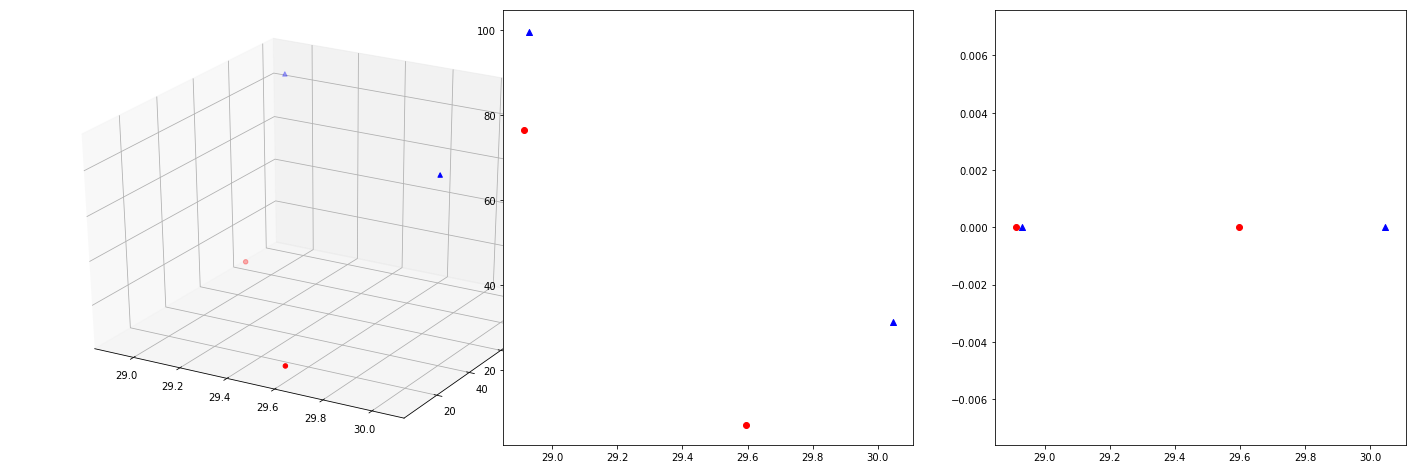

In [7]:
plt.show()

http://distill.pub/2016/misread-tsne/

# other measures
- topic coherence (Reading Tea Leaves: How Humans Interpret Topic Models)
  - word / topic intrusion
  - perplexity
  - Automatic Word Sense Discrimination Schütze 1998
  - Automatic Evaluation of Topic Coherence Newman et. al 2010
    - ontological similarity to link overlap and term co-occurrence
    - wordnet (path distance, Leacock-Chodorow, Wu-Palmer, Hirst-St Onge, Resnik Information Content, Lin's measure, Jiang-Conrath, LESK)
  - inter-annotator agreement, but of what exactly (useful == coherent, unuseful==incoherent)
  - inter-annotator agreement on labels for topics
- the measures take into account only information that is present, not information that isn't present
  - do you want topics that are highly separated or largely overlapping

In [13]:
x

array([ 0.,  1.,  2.,  3.,  4.])

In [46]:
np.arange(binom.ppf(0.01, n, p),
          binom.ppf(0.99, n, p))

array([ 12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.])

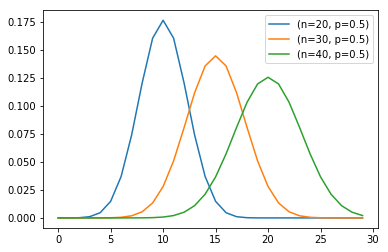

In [67]:
from scipy.stats import binom
import numpy as np

fig, ax = plt.subplots(1, 1)
for n, p in [(20, 0.5), (30, 0.5), (40, 0.5)]:
    x = np.arange(binom.ppf(0.01, n, p),
                  binom.ppf(0.99, n, p), step=1)
    ax.plot(np.arange(0, 30), binom.pmf(np.arange(0, 30), n, p), label=f'(n={n}, p={p})')
plt.legend()
plt.show()

---

## distributional semantics

- word2vec, glove, APTs and distributional composition
- the meaninig of a word is *"the company it keeps"* - what's the meaning of two or more words put together
- intrinsic evaluation is nearly impossible

- river delta, river estuary (suisto, estuaari?) - why doesn't finnish have an equivalent for estuary
- good, bad, pear, apple
- blue, red, green?

## analogy task

`king - man + woman == queen`

`cider - alchohol == applejuice`

`apple + drink = cider`

`cider - apple + (hops + barley) == beer`

- is `good` closer to `apple` than it is to `bad`?
- is `good` closer to `maybe` than it is to `and`?


## forget trying to define what the meaning of meaning is and use the damn thing

- none of the deep learning models are attempting to understand *language*, they are all treying to solve a task by possibly understanding language
- evaluating on a task is also not always easy because humans tend to be messy creatures (multi-label classification, while *sports* is clear *celebriry gossip* is less clear)

## what does this mean for NLP?

In [1]:
from spacy import en

In [3]:
spc = en.English()

In [11]:
len(spc.vocab)

1297536

In [10]:
lex_good = spc.vocab['good']
lex_bad = spc.vocab['bad']
lex_good.vector - lex_bad.vector

array([ 0.03778473, -0.03715277, -0.07361357, -0.01294211,  0.02956894,
        0.00120951,  0.00651724, -0.04558603, -0.04687905, -0.04818122,
       -0.05862857,  0.0269573 , -0.03065341, -0.02568185,  0.0108215 ,
        0.03609811, -0.00549456, -0.00496092,  0.01636782, -0.11323725,
        0.00400667,  0.03294041, -0.03766143, -0.11303058, -0.01312381,
        0.00074617, -0.02796576,  0.03918718, -0.06753656,  0.04056126,
       -0.02435833,  0.03351083,  0.05406209, -0.05045499, -0.03866494,
       -0.11557291, -0.0241404 , -0.02356568, -0.00907446, -0.03900382,
        0.03083578, -0.0040055 ,  0.03728203,  0.01200607, -0.06109978,
        0.01538801,  0.01623785, -0.00788699,  0.01040638, -0.09391987,
        0.03025245,  0.06502789, -0.0257586 , -0.02438577, -0.08735697,
        0.00546392, -0.04054803, -0.01161486,  0.04618217,  0.08720689,
       -0.01748072,  0.07930992, -0.02152181, -0.0473533 ,  0.06699783,
       -0.05474082, -0.01087604, -0.01853025, -0.07290894,  0.10

- https://www.youtube.com/watch?v=uLgn3geod9Q (How a dictionary writer defines English)

- https://youtu.be/uLgn3geod9Q?t=2m3s"

"*when we revise a dictionary, you go through it A-Z and you take all of the instances for the word that you're looking at. You're mathing up the word and its **contextual use** ... *"

*antidisestablishmentarianism*



Demonstration of the Topic Coherence model in `gensim`.
- https://nbviewer.jupyter.org/github/dsquareindia/gensim/blob/280375fe14adea67ce6384ba7eabf362b05e6029/docs/notebooks/topic_coherence_tutorial.ipynb

Topic Coherence
- http://qpleple.com/topic-coherence-to-evaluate-topic-models/